In [1]:
# load loaders from data/loaders/train , test , val .pt
import torch

train_loader = torch.load('data/loaders/train_loader.pt',weights_only=False)
test_loader = torch.load('data/loaders/test_loader.pt',weights_only=False)
val_loader = torch.load('data/loaders/val_loader.pt',weights_only=False)



In [2]:
print(torch.__version__)

2.9.0+cpu


---
- usegin pretrained googlenet model (trasferlearning)
- 

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models


# device config to use gpu if its available else cpu 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device : ",device)

# Add after your device setup:
if device == 'cuda':
    torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Load pretrained GoogLeNet
# pretrained ? 
# model = models.googlenet(pretrained=True) # Old way (deprecated):

model = models.googlenet(weights='IMAGENET1K_V1')  # Modern PyTorch


# freeze all parameters (transfer learning)
for param in model.parameters():
    param.requires_grad = False



# replace fully connected part (fn)
# with a sequential fully connected network adapted for the specific classification task (Transfer Learning).



# Get the input features for the final FC layer
in_features = model.fc.in_features # 1024

num_classes = 4  # blood categories

# replace the FC 
model.fc = nn.Sequential(
    nn.Linear(in_features, 512), #hidden layer
    nn.ReLU(),
    nn.Dropout(0.6),

    # nn.BatchNorm1d(512),
    # nn.Linear(512, 256),
    # nn.ReLU(),
    # nn.Dropout(0.3),
    
    # this layer use softmax by default
    nn.Linear(512, num_classes)# final layer 
)

model = model.to(device)

device :  cpu


Determiner le learning rate et loss function et aussi l’optomizer pour le modele


In [4]:

# learning rate 
learning_rate = 0.001 

# loss function - CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# adam as optimzer
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=learning_rate,
    weight_decay=1e-4  # Adds L2 regularization penalty to loss function
)

# What Weight Decay Does:
# - Adds L2 regularization penalty to loss function
# - Prevents weights from becoming too large
# - Reduces overfitting (especially important with small datasets)
# - Helps model generalize better to unseen data



In [5]:

# 5. Training and validation functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total


In [ ]:
# train model
import time

epochs = 20
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []


for epoch in range(epochs):
    start_time = time.time()
    print(f"\nEpoch [{epoch+1}/{epochs}]")

    # Training phase
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store metrics for plotting later
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # time calc stuf
    epoch_time = time.time() - start_time
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"Time: {epoch_time:.2f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_googlenet.pth')
        print("✅ Best model saved!")


# 7. Final evaluation on test set
print("\nEvaluating on Test Data...")
model.load_state_dict(torch.load('best_googlenet.pth', map_location=device))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")




Epoch [1/20]


c:\Users\alibo\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Evaluate and test the model after training to measure its performance, accuracy, and generalization capability on unseen data.

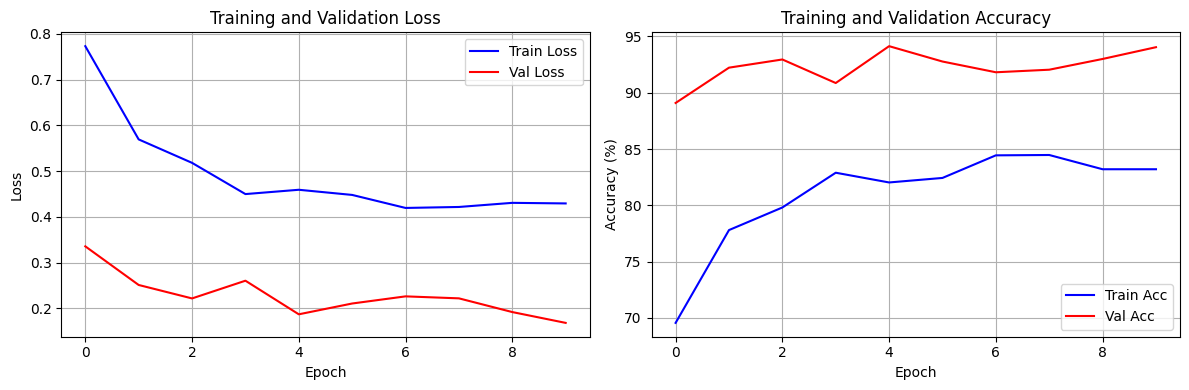

In [ ]:
# Add training visualization after training:
import matplotlib.pyplot as plt

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', color='blue')
ax2.plot(val_accs, label='Val Acc', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model.

# After training is complete:
torch.save(model.state_dict(), 'googlenet_trained_weights.pth')
# Or to save the whole model and its weights:
# torch.save(model, 'googlenet_full_model.pth')